# Figures 3 and 4

Propagating a circle through random networks

## Setup

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

from __future__ import print_function
import os, sys
from tqdm import tqdm

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True
plt.rcParams['image.cmap'] = 'viridis'

# Add cornet and Theano to path
sys.path.insert(0, '../')
sys.path.insert(0, '/home/poole/Theano_clean')

# Output figure directory
figure_dir = "../writeup/figures"
results_dir = "../results"
if not os.path.exists(figure_dir):
    raise ValueError("Figure directory does not exist. Create it or change figure_dir above.")
if not os.path.exists(results_dir):
    raise ValueError("Results directory does not exist. Create it or change results_dir above.")

Populating the interactive namespace from numpy and matplotlib


## Parameters

In [18]:
n_hidden_layers = 40 # Number of hidden layers
n_hidden_units = 1000 # Number of hidden units
din = n_hidden_units # Input dimensionality
nonlinearity = 'tanh' # Keras-compatiable activation nonlinearity
nonlinearity_str = nonlinearity # Printable name for nonlinearity
nonlinearity_np = np.tanh # Numby-callable nonlinearity
n_interp = 500 # Number of points to interpolate along the input angle, theta

# First and second derivatives of nonlinearity, needed for curvature computations
from scipy.stats import hypsecant
def sech(x):
    return hypsecant.pdf(x) * np.pi
phi = np.tanh
dphi = lambda x: sech(x)**2
d2phi = lambda x: 2 * (np.tanh(x)**3 - np.tanh(x))

In [3]:
from cornet.constants import weight_sigmas, bias_sigmas, widxs, bidxs
weight_sigmas = weight_sigmas[widxs]
bias_sigmas = bias_sigmas[bidxs][:1]
nw = len(weight_sigmas)
nb = len(bias_sigmas)

In [7]:
ts = np.linspace(-np.pi, np.pi, n_interp, endpoint=False)
# Make sure 0 is one of the angles
assert len(np.flatnonzero(ts==0)) == 1

## Simulations

Construct a model that maps an angle to an input vector in $d$ dimensions, and then passes it through a deep fully connected neural network.

The `GreatCircle` input layer takes a scalar angle, $\theta$, as input, and outputs the point along a great cirlce in $d$ dimensions as its output:
$$\mathtt{gc\_input}(\theta) = \sqrt{q} \left(u_0 \cos(\theta) + u_1 \sin (\theta)\right)$$
where $\theta, q \in \mathbb{R}$ and $u_0, u_1 \in \mathbb{R}^d$.

In [8]:
from cornet.net import RandNet, GreatCircle
gc_input = GreatCircle(din)
net = RandNet(din, n_hidden_units, n_hidden_layers, nonlinearity=nonlinearity, input_layer=gc_input)

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5004)
Using Theano backend.


### Compute the fixed point of the squared length from theory, $q^*(\sigma_w, \sigma_b)$
This is needed to appropriately scale the input norm for the simulations

In [9]:
from cornet.theory import q_fixed_point
qstars = np.zeros((nw, nb))
for widx, weight_sigma in enumerate(tqdm(weight_sigmas)):
    for bidx, bias_sigma in enumerate(bias_sigmas):
        _, qstars[widx, bidx]  =  q_fixed_point(weight_sigma, bias_sigma, nonlinearity_np)

100%|██████████| 3/3 [00:00<00:00, 250.04it/s]


### Compute statistics on simulated network

In [10]:
from cornet.curvature import compute_curvature_statistics
stats = compute_curvature_statistics(net, ts, [0], weight_sigmas, bias_sigmas, qstar=qstars, include_hessian=True)

100%|██████████| 3/3 [02:22<00:00, 68.98s/it]


In [11]:
kappa = stats['local_curvatures'].mean(-2)
kappa_std = stats['local_curvatures'].std(-2)

expansion = (np.linalg.norm(stats['jacs'], axis=-1)**2).mean((-3, -1))
expansion_std = (np.linalg.norm(stats['jacs'], axis=-1)**2).std((-3, -1))

lg_mean = stats['global_curvatures'].squeeze() / np.sqrt(n_hidden_units)
lg_std = (stats['global_curvatures_raw']/np.sqrt(n_hidden_units)).std(-2).squeeze()

Le = np.sqrt(np.linalg.norm(stats['jacs'], axis=-1)**2).mean((-3, -1))
Lg = stats['global_curvatures']
R = np.sqrt((stats['acts_centered']**2).sum(-1).mean((2, 4)))
normalized_extrinsic_length = Le / R
grassmanian_length = Lg

from collections import OrderedDict
metrics = OrderedDict([('kappa', kappa), ('kappa_std', kappa_std), ('expansion', expansion), ('expansion_std', expansion_std), ('R',R), ('Le', Le), ('Le_norm',normalized_extrinsic_length), ('Lg',Lg)])

## Theory: compute autocorrelation as a function of layer


In [15]:
from cornet.theory import covmap
nctraj = 5
cin = crange_traj = np.linspace(0, 1, nctraj, endpoint=False)
thetas = ts
nt = len(ts)
ctrajs = np.zeros((len(widxs), nt, n_hidden_layers))
bias_sigma = bias_sigmas[0]
for i, weight_sigma in enumerate(tqdm(weight_sigmas)):
    q1 = qstars[i, 0]
    ctrajs[i, :, 0] =  q1 * np.cos(thetas)
    for t in xrange(1, n_hidden_layers):
        ctrajs[i, :, t] = covmap(q1, q1, ctrajs[i, :, t-1], weight_sigma, bias_sigma, nonlinearity_np)
    ctrajs[i] /= q1
ctrajs_ = ctrajs.copy()

# Due to numerical instability, correlations starting at 1 decay away from 1
# We know that 1 is a fixed point to the analytic equations, so we hackily fix it here.
ctrajs[:, np.flatnonzero(ts==0)[0], :] = 1.0

100%|██████████| 3/3 [05:25<00:00, 109.24s/it]


# Figure 3: Propagating a circle through three random networks.
(A) Projection of hidden activations of simulated networks at layer 5 and 10 onto their first three principal components. Insets show the fraction of variance explained by the first 5 singular values. For networks with large weights (bottom), the distribution of singular values gets flatter and the projected curve is more tangled. (B) The autocorrelation of hidden activations as a function of layer for simulated networks. (C) The theoretical predictions from 6 (solid lines) compared to the average (dots) and standard deviation (shaded) across θ in a simulated network.

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


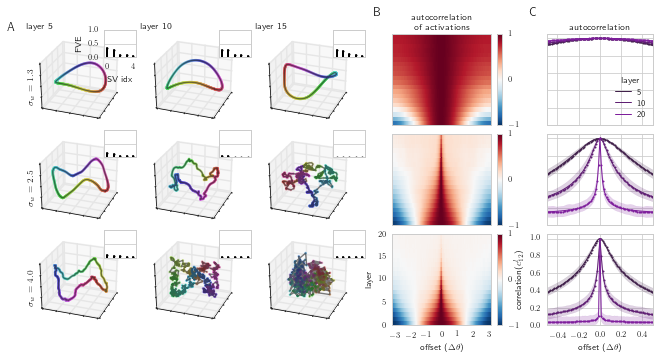

In [16]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.mplot3d import Axes3D
from cornet.viz import add_label, pcolor
cmap = mpl.colors.ListedColormap(sns.color_palette("hls", n_interp))

sub = 10
nws = len(weight_sigmas)

idx = [5, 10, 15]
n = len(idx)

figure(figsize=(9, 5))
bidx = 0
gs = GridSpec(nws, n + 4, width_ratios=[1.5]*n + [.2, 1.75,.2, 1.5])
for widx, weight_sigma in enumerate(weight_sigmas):
    
    # Panel A - Projections of hidden activaitons onto first three PCs
    hs = stats['acts'][widx, bidx, 0]
    hs_proj = []
    singular_values = []
    for i, h in enumerate(hs):
        h = h - h.mean(0, keepdims=True)
        u, s, v = np.linalg.svd(h, full_matrices=False)
        # Scale up by singular values (equivalent to projecting onto Vs)
        # and normalize by the maximum value so the plots are scaled similarly.
        norm_s = s[:3] / s[:3].max()
        u = (norm_s[None, :]) * u[:, :3] 
        u = u/ np.abs(u).max()
        singular_values.append(s)
        hs_proj.append(u[:, :3])

    for i, lidx in enumerate(idx):
        ax = subplot(gs[widx, i], projection='3d')
        ax.scatter(hs_proj[lidx][:, 0], hs_proj[lidx][:, 1],hs_proj[lidx][:, 2], c=ts, edgecolors='none', cmap=cmap, s=7)
        ax.plot(hs_proj[lidx][:, 0], hs_proj[lidx][:, 1], hs_proj[lidx][:, 2],color='k', zorder=0, alpha=.5)
        ax.view_init(30, -160)
        if widx == 0:
            title('layer %d'%lidx, loc='left')
        axis('tight')
        pmax = 1
        xlim(-pmax, pmax); ylim(-pmax, pmax); ax.set_zlim(-pmax, pmax)
        ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([])
        if i == 0:
            if widx == nws - 1:
                ax.zaxis.set_rotate_label(False) 
                ax.set_zlabel(r'$\sigma_w=%.1f$'%weight_sigma, labelpad=-15, rotation=90)
            else:
                ax.zaxis.set_rotate_label(False) 
                ax.set_zlabel(r'$\sigma_w=%.1f$'%weight_sigma, labelpad=-15, rotation=90)
                
        # Draw inset spectrum
        borderpad = -.5
        ax2 = inset_axes(gca(), "30%", "30%", borderpad=borderpad)
        markerline, stemlines, baseline = ax2.stem((singular_values[lidx])/singular_values[lidx].sum(), lw=1, linefmt='k-', markerfmt='ko', basefmt=' ', clip_frame=False)#, 'o-', color='k', lw=1)
        plt.setp(markerline, 'markersize', 2)
        plt.setp(stemlines, 'lw', 2)
        ax2.xaxis.grid(False)
        xticks([0, 4, 10])
        yticks([0, 0.5, 1.0])
        if i !=0 or widx != 0:
            gca().set_xticklabels([])
            gca().set_yticklabels([])
        else:
            xlabel('SV idx')
            ylabel('FVE')
        ylim(0, 1)
        xlim(-.5, 4.5)
        if i == 0 and widx == 0:
            add_label('A', xoff=-2.8)


    # PANEL B --- autocorrelation of activations
    subplot(gs[widx, n+1])
    pcolor(ts, np.arange(n_hidden_layers), stats['r_acts'][widx, bidx].T, cmap='RdBu_r', vmin=-1, vmax=1)
    axis('tight')
    if widx == 0:
        title('autocorrelation\nof activations')
        add_label('B')

    if widx == nws - 1:
        xlabel(r'offset ($\Delta\theta$)')
        ylabel('layer')
    else:
        xticks([]); yticks([]);
    xlim(-np.pi, np.pi)
    ylim(0, 20)
    colorbar(ticks=(-1, 0, 1))
    
    # PANEL C --- theory vs. simulation on autocorrelations
    subplot(gs[widx, n+3])
    pidx = widx    
    hsub = 10
    hidx = [5, 10, 20]
    a = stats['r_acts'][pidx, 0, :, hidx].T
    b = stats['r_acts_std'][pidx, 0, :, hidx].T
    c = ctrajs[pidx, :, hidx].T
    coff = 1
    pal = sns.dark_palette("purple", len(hidx)+coff, input="xkcd")[coff:]
    sns.set_palette(pal)
    for i, (a, b, c) in enumerate(zip(a.T, b.T, c.T)):
        fill_between(ts, a-b, a+b, color=pal[i], alpha=0.2, label='_nolegend_')
        plot(ts, a, 'o', c=pal[i], markersize=2, label='_nolegend_')
        plot(ts, c, '-', c=pal[i], lw=1)
    xlim(-np.pi/2, np.pi/2.0)
    xlim(-0.5, 0.5)
    if widx == 0:
        legend(['%d'%(d) for d in hidx] , title='layer', loc='lower right')
        title('autocorrelation')
        add_label('C')

    if widx == nws -1:
        xlabel(r'offset ($\Delta\theta$)')
        ylabel('correlation($c_{12}^l$)')
    else:
        gca().set_xticklabels([])
        gca().set_yticklabels([])
    ylim(0, 1.05)


gcf().tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
savefig(os.path.join(figure_dir, "fig3_autocorr.pdf" ), bbox_inches='tight')

In [22]:
# Save data for Figure 2
overwrite = False
autocorr_data_fn = os.path.join(results_dir, "autocorr.npz")
if overwrite or not os.path.exists(autocorr_data_fn):
    np.savez(autocorr_data_fn, ts=ts, acorr_mu=stats['r_acts'], acorr_std=stats['r_acts_std'])
else:
    print("Warning: autocorr data already exists at %s. Not overwriting"%autocorr_data_fn)

### Curvature metrics from theory

In [24]:
from cornet.theory import compute_chi1, compute_chi2, kappa_map

chi1 = np.zeros((nw, nb))
chi2 = np.zeros((nw, nb))
kappas = np.zeros((nw, nb, n_hidden_layers))
g2s = np.zeros((nw, nb, n_hidden_layers))

for widx, weight_sigma in enumerate(tqdm(weight_sigmas)):
    for bidx, bias_sigma in enumerate(bias_sigmas):
        g0 =  qstars[widx, bidx]# / din
        kappa0 =  1./((qstars[widx, bidx]) * din)
        g2s[widx, bidx, 0] = g0
        kappas[widx, bidx] = kappa0
        chi1[widx, bidx] = compute_chi1(qstars[widx, bidx], weight_sigma, bias_sigma, dphi)
        chi2[widx, bidx] = compute_chi2(qstars[widx, bidx], weight_sigma, bias_sigma, d2phi, hidden_units=n_hidden_units)
        for lidx in xrange(1, n_hidden_layers):
            kappas[widx, bidx, lidx] = kappa_map(kappas[widx, bidx, lidx  -1], chi1[widx, bidx], chi2[widx, bidx])
            g2s[widx, bidx, lidx] = chi1[widx, bidx] * g2s[widx, bidx, lidx -1]

100%|██████████| 3/3 [00:00<00:00, 20.02it/s]


### Scaled curvature metrics from simulation

In [44]:
kappas_sim = metrics['kappa']
kappas_sim_std = metrics['kappa_std']

gs_sim = (metrics['expansion'] / n_hidden_units).squeeze()
gs_sim_std = (metrics['expansion_std'] / np.sqrt(n_hidden_units)).squeeze()
gs_sim_std = (metrics['expansion_std'] / (n_hidden_units)).squeeze()

g2s = np.squeeze(g2s)
ke_sim = metrics['Lg']

ktheory =  ((kappas )[:, bidx]) / np.sqrt(N)
ksim = ((kappas_sim)[:, bidx]) / np.sqrt(N)
ksim_std = ((kappas_sim_std)[:, bidx]) / np.sqrt(N)

# Figure 4 C-E: Propagation of extrinsic curvature and length.
(C-E) Propagation of curvature metrics based on both theory derived from iterative maps in (3), (6) and (8) (solid lines) and simulations using (1) (dots). 

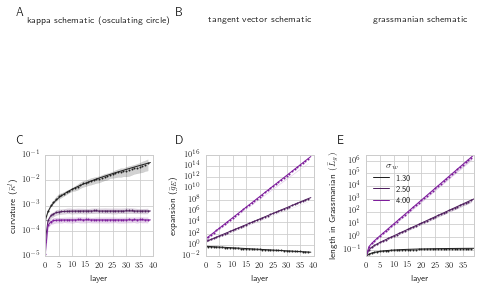

In [75]:
pal = sns.dark_palette("purple", len(widxs), input="xkcd")
sns.set_palette(pal)

figure(figsize=(9,4))
gs = GridSpec(2, 4)
subplot(gs[0, 0])
title('kappa schematic (osculating circle)')
axis('off')
xoff = -.2
yoff = 1.2
add_label("A", xoff=xoff, yoff=yoff)

subplot(gs[0, 1])
title('tangent vector schematic')
axis('off')
add_label("B", xoff=xoff, yoff=yoff)

subplot(gs[0, 2])
title('grassmanian schematic')
axis('off')
subplot(gs[1, 0])
bidx = 0
xx = np.arange(n_hidden_layers)

N = n_hidden_layers
for i in xrange(ksim.shape[0]):
    fill_between(xx,  (ksim[i]-ksim_std[i]),  (ksim[i]+ksim_std[i]), color=pal[i], alpha=0.2, label='_nolegend_')
    semilogy(xx,  ksim[i], 'o', c=pal[i], markersize=2, label='_nolegend_')
    semilogy(xx,  ktheory[i], '-', c=pal[i], lw=1)
xlabel('layer')
ylabel(r'curvature ($\bar{\kappa}^l$)')
add_label("C", xoff=xoff, yoff=yoff)

# Panel D -- expansion
subplot(gs[1, 1])
for i in xrange(ksim.shape[0]):
    semilogy(xx, gs_sim[i], 'o', c=pal[i], markersize=2, label='_nolegend_')
    semilogy(xx, g2s[i], '-', c=pal[i], lw=1)\
    fill_between(xx, gs_sim[i]-gs_sim_std[i], gs_sim[i]+gs_sim_std[i], color=pal[i], alpha=0.2, label='_nolegend_', zorder=0)

xlabel('layer')
ylabel(r'expansion ($\bar{g}_E$)')
add_label("D", xoff=xoff, yoff=yoff)

# Panel E -- length in Grassmanian
subplot(gs[1, 2])
for i in xrange(ksim.shape[0]):
    fill_between(xx, lg_mean[i]-lg_std[i], lg_mean[i]+lg_std[i], color=pal[i], alpha=0.2, label='_nolegend_', zorder=0)
    semilogy(xx, lg_mean[i], 'o', c=pal[i], markersize=2, label='_nolegend_')
    semilogy(xx, np.sqrt(np.sqrt(N) * ktheory*g2s.squeeze())[i], '-', c=pal[i], lw=1)
xlabel('layer')
ylabel(r'length in Grassmanian $(\bar{L}_g)$')
axis('tight')
legend(['%.2f'%w for w in weight_sigmas], loc='upper left', title=r'$\sigma_w$')
axis('tight')
add_label("E", xoff=xoff, yoff=yoff)

gcf().tight_layout()
savefig(os.path.join(figure_dir, "fig4_curvature.pdf" ), bbox_inches='tight')